### Author: Babaniyi Olaniyi

**Task:** Build a model that acts as a filter or auto-moderator for toxic and hateful comments.

**Approach**
1. Data cleaning 
         a. Removing unwanted characters
         b. Removing stopwords
         c. Lemmatization
2. Feature engineering - Including new features such as number of words and part of speech.


3. Exploratory Descriptive Analysis (EDA)
        a. Generate a word cloud to view the most common words
        b. Using a barplot to view the most common words
    
4. Modeling - Building a model that filters comments by assigning probabilities according to the following groups: toxicity, severe toxicity, obscene, threat, insult, identity attack and sexual explicit. The following techniques are used:
        a. Using only alphanumeric words as tokens
        b. Applying dimension reduction and select best 300 best features
        c. Scaling to relevant features using MaxAbsScaler
        d. Including interaction terms using SparseInteractions instead of CountVectoriser for computation ease
        e. Using Hashing for memory efficiency

5. Recommendations


In [1]:
# Import packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import nlp # package that contains the needed dataset


## 1. Data Cleaning

In [2]:
#______________Loading the data
news_dataset = nlp.load_dataset('civil_comments')
test_data = pd.DataFrame.from_dict(news_dataset['test'])
train_data = pd.DataFrame.from_dict(news_dataset['train'])
train_data.dtypes


#_____________ Classifying the target variables since they have probabilities assigned to them_________

"""
**Assumptions**

I assume if a variable has a probabilty greater than 0.5 it belongs to a class except for severe_toxicity
I assume if the probability of a word being toxic is above 50% then it should be assigned as toxic
However, if the probabilty of a word being toxic is 60%, then it's severely toxic.

"""

train_data['new_toxicity'] = np.where(train_data['toxicity']>=0.5,1,0)
train_data['new_severe_toxicity'] = np.where(train_data['severe_toxicity']>=0.6,1,0)
train_data['new_obscene'] = np.where(train_data['obscene']>=0.5,1,0)
train_data['new_threat'] = np.where(train_data['insult']>=0.5,1,0)
train_data['new_identity_attack'] = np.where(train_data['identity_attack']>=0.5,1,0)
train_data['new_sexual_explicit'] = np.where(train_data['sexual_explicit']>=0.5,1,0)
train_data['new_insult'] = np.where(train_data['insult']>=0.5,1,0)


#__________Proportion of variables in each class

def icount(data):
    print(data.value_counts())
    
icount(train_data['new_toxicity'])
icount(train_data['new_severe_toxicity'])
icount(train_data['new_obscene'])
icount(train_data['new_threat'])
icount(train_data['new_insult'])
icount(train_data['new_identity_attack'])
icount(train_data['new_sexual_explicit'])



Using custom data configuration default


0    1660540
1     144334
Name: new_toxicity, dtype: int64
0    1804871
1          3
Name: new_severe_toxicity, dtype: int64
0    1795271
1       9603
Name: new_obscene, dtype: int64
0    1698340
1     106534
Name: new_threat, dtype: int64
0    1698340
1     106534
Name: new_insult, dtype: int64
0    1791464
1      13410
Name: new_identity_attack, dtype: int64
0    1800188
1       4686
Name: new_sexual_explicit, dtype: int64


It's obvious we have a highly imbalanced dataset according the proportions above.

### Data cleaning - Removing special characters

In [3]:
# _____________________Removing characters

import re

def clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

train_data = clean_text(train_data, "text", "text_clean")
train_data['text_clean'].head()

0    this is so cool its like would you want your m...
1    thank you this would make my life a lot less a...
2    this is such an urgent design problem kudos to...
3    is this something ill be able to install on my...
4                  haha you guys are a bunch of losers
Name: text_clean, dtype: object

### Data Cleaning - Removing stopwords

In [4]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['the', 'that', 'but', 'they', 'and', 'you', 'we', 'he', 'this', 'not', 'what', 'so',
             'I\'m', 'are', 'if', 'to', 'said', 'say', 'don\'t'])

train_data['text_clean'] = train_data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['text_clean'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babaniyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    cool like would want mother read really great ...
1    thank would make life lot less anxietyinducing...
2        urgent design problem kudos taking impressive
3            something ill able install site releasing
4                               haha guys bunch losers
Name: text_clean, dtype: object

### Data Cleaning - Lemmatization

In [6]:
#_______________Lemmatizing
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text


train_data['text_tokens'] = train_data['text_clean'].apply(lambda x: word_tokenize(x))

train_data['text_tokens_lemma'] = train_data['text_tokens'].apply(lambda x: word_lemmatizer(x))
train_data['text_tokens_lemma'].head()

train_data['text'] = train_data['text_tokens_lemma'].apply(lambda x: ' '.join(x))

## 2. Feature Engineering 
I created new features i think will be of use. They include: Number of words, nouns, pronouns, verbs, adverbs and adjectives in a sentence.

In [7]:
#________________Number of words
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x.split())))    


#_______________ Part of Speech Counts

from textblob import TextBlob

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train_data['noun_count'] = train_data['text'].apply(lambda x: check_pos_tag(x, 'noun'))
train_data['verb_count'] = train_data['text'].apply(lambda x: check_pos_tag(x, 'verb'))
train_data['adj_count'] = train_data['text'].apply(lambda x: check_pos_tag(x, 'adj'))
train_data['adv_count'] = train_data['text'].apply(lambda x: check_pos_tag(x, 'adv'))
train_data['pron_count'] = train_data['text'].apply(lambda x: check_pos_tag(x, 'pron'))

train_data['word_count'].head()

0     94
1    113
2     64
3     60
4     33
Name: word_count, dtype: int64

## 3. Exploratory Analysis - word cloud
Since the training data is large 1.8M, it will take a **very** long time to get get good plots hence i decided to use the first 10,000 rows.

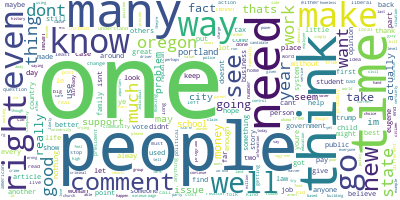

In [8]:
###########################
#_________ Generate a Word Cloud

sample_data = train_data[:10000]


# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(sample_data['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

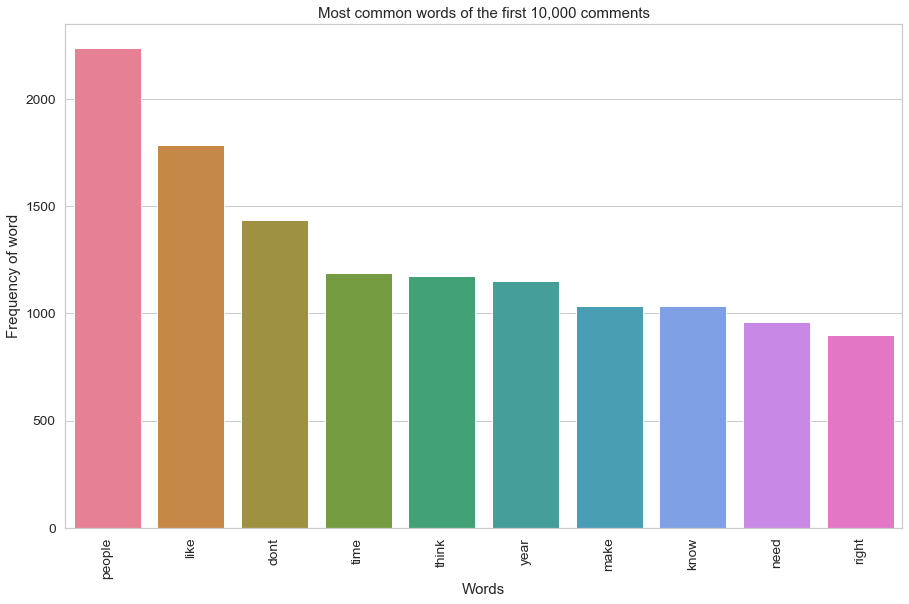

In [10]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer


sns.set_style('whitegrid')

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Frequency of word')
    plt.title('Most common words of the first 10,000 comments')
    plt.show()
    
    

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(sample_data['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


## 4. Modeling
The aim is to build a model that acts as a filter or auto-moderator for comments.
The technique used is explained in the introductory paragraph.
In addition, i used a pipeline for ease-of-use and to avoid data leakage.


In [11]:
# Importing packages

from SparseInteractions import SparseInteractions
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [12]:
train_data = train_data.drop(['text_clean', 'text_tokens', 'text_tokens_lemma'], axis=1)

get_text_data = FunctionTransformer(lambda x: x['text'], validate =False)
get_text_data.fit_transform(train_data.head(5))

get_numeric_data = FunctionTransformer(lambda x: x['word_count'], validate =False)
get_numeric_data.fit_transform(train_data.head(5))

alpha_tk = '[A-zA-z0-9]+(?=\\s+)'
chi_k = 300


numeric_features = ['word_count','noun_count','verb_count','adj_count','adv_count','pron_count']

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

text_features = ['text']

text_transformer = Pipeline([
        ('selector', get_text_data),
        ('Vectorizer', HashingVectorizer(token_pattern=alpha_tk, ngram_range=(1,2), alternate_sign=False)),
        ('dim_red',SelectKBest(chi2,chi_k))
        ])

preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, numeric_features),
            ('txt', text_transformer, text_features)])


### Training the model using OneVsRest Logistic regression
**P.S:** Because of my statisitcs background, i tend to have a bias for logistic regression because of the ease of interpretability and the result is not a black box compared to advanced machine learning models.

In this case, since we have more than 1 target variable (in fact we have 7 target variables) and i classified the cardinality as 0's and 1's the situation is referrred to as **multilabel classification**.

<a href = https://scikit-learn.org/stable/modules/multiclass.html#multiclass> Read more about it here </a>

In [14]:
#_______Fitting the model and observing the predict power on the training data____________

clfr5 = Pipeline(steps=[('preprocessor', preprocessor),
                       ('int', SparseInteractions(degree=2)),
                       ('sc', MaxAbsScaler()),
                      ('classifier', OneVsRestClassifier(LogisticRegression(C=10)))])

target_na = ['new_toxicity', 'new_severe_toxicity', 'new_obscene', 'new_threat',
       'new_insult', 'new_identity_attack', 'new_sexual_explicit']

feat_na = ['text','word_count','noun_count','verb_count','adj_count','adv_count','pron_count']
clfr5.fit(train_data[feat_na], train_data[target_na])
tr_pred5 = clfr5.predict(train_data[feat_na])



from sklearn.metrics import classification_report

print(classification_report(train_data[target_na], tr_pred5, target_names = target_na))

/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


                     precision    recall  f1-score   support

       new_toxicity       0.78      0.37      0.50    144334
new_severe_toxicity       1.00      1.00      1.00         3
        new_obscene       0.75      0.30      0.43      9603
         new_threat       0.79      0.39      0.52    106534
         new_insult       0.79      0.39      0.52    106534
new_identity_attack       0.60      0.18      0.28     13410
new_sexual_explicit       0.70      0.24      0.36      4686

          micro avg       0.78      0.37      0.50    385104
          macro avg       0.77      0.41      0.52    385104
       weighted avg       0.77      0.37      0.50    385104
        samples avg       0.03      0.03      0.03    385104



/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Well, our model does fairly well. 
Let's see the model perfomance on the test data

In [16]:
test_data = clean_text(test_data, "text", "text_clean")
test_data['text'] = test_data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x.split())))    

test_data['noun_count'] = test_data['text'].apply(lambda x: check_pos_tag(x, 'noun'))
test_data['verb_count'] = test_data['text'].apply(lambda x: check_pos_tag(x, 'verb'))
test_data['adj_count'] = test_data['text'].apply(lambda x: check_pos_tag(x, 'adj'))
test_data['adv_count'] = test_data['text'].apply(lambda x: check_pos_tag(x, 'adv'))
test_data['pron_count'] = test_data['text'].apply(lambda x: check_pos_tag(x, 'pron'))


test_data['new_toxicity'] = np.where(test_data['toxicity']>=0.5,1,0)
test_data['new_severe_toxicity'] = np.where(test_data['severe_toxicity']>=0.6,1,0)
test_data['new_obscene'] = np.where(test_data['obscene']>=0.5,1,0)
test_data['new_threat'] = np.where(test_data['insult']>=0.5,1,0)
test_data['new_identity_attack'] = np.where(test_data['identity_attack']>=0.5,1,0)
test_data['new_sexual_explicit'] = np.where(test_data['sexual_explicit']>=0.5,1,0)
test_data['new_insult'] = np.where(test_data['insult']>=0.5,1,0)


pred5_prob = clfr5.predict(test_data[feat_na])
print(classification_report(test_data[target_na], pred5_prob, target_names = target_na))

                     precision    recall  f1-score   support

       new_toxicity       0.75      0.29      0.42      7777
new_severe_toxicity       0.00      0.00      0.00         0
        new_obscene       0.62      0.23      0.33       543
         new_threat       0.74      0.30      0.43      5776
         new_insult       0.74      0.30      0.43      5776
new_identity_attack       0.39      0.06      0.11       687
new_sexual_explicit       0.57      0.13      0.21       240

          micro avg       0.74      0.28      0.41     20799
          macro avg       0.55      0.19      0.27     20799
       weighted avg       0.73      0.28      0.41     20799
        samples avg       0.02      0.02      0.02     20799



/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Users/babaniyi/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall',

The performance is okay for a simple model. It's important to recall the aim of the model is to generate the probabilities of a comment being toxic, severly toxic, obscene, threat, insult, identity attack and sexual explicit not **accuracies**.
The probabilities are given below:


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

p_prob = clfr5.predict_proba(test_data[feat_na])

pred_df = pd.DataFrame(columns = target_na, index = test_data.index, data = p_prob)

print(sqrt(mean_squared_error(test_data['toxicity'], pred_df['new_toxicity'])))
print(sqrt(mean_squared_error(test_data['severe_toxicity'], pred_df['new_severe_toxicity'])))
print(sqrt(mean_squared_error(test_data['obscene'], pred_df['new_obscene'])))
print(sqrt(mean_squared_error(test_data['threat'], pred_df['new_threat'])))
print(sqrt(mean_squared_error(test_data['insult'], pred_df['new_insult'])))
print(sqrt(mean_squared_error(test_data['identity_attack'], pred_df['new_identity_attack'])))
print(sqrt(mean_squared_error(test_data['sexual_explicit'], pred_df['new_sexual_explicit'])))

0.17163966495325675
0.02347668530293907
0.06024089217238084
0.1446228526189603
0.15330861668984816
0.07463181045736975
0.042203775785213504


Looking at the probabilites and calculating the root mean squared errors of the probabilities, we see that the model performs well, many thanks to the statistical intuition applied (such as including interaction terms, using hashing vectorizer, etc.).

We see that for the the test data, the RMSE rate of our model is 17% for predicting toxicity, 2% for severe toxicity, 6% for obscene, 14% for threat, 15% for insult, 7% for identity attack and 4% for sexual explicit comments.

## Recommendation

1. **Time:** The data is large and it takes time to train, one can decide to train the model on say 50% of the data instead of using the whole data.


2. **Using other machine models:** for instance naive bayes, SVM, SGD Classifier and other deep learning techniques are known to perform well on NLP data.


3. **Hyperparameter tuning:** Since i used the logistic regression model in this article, you may decide to tune the inverse regularisation strength parameter C. Recall a big C implies less regularisation and a small C implies stronger regularisation. I decided against doing that in this article because the data is large and i don't have enough computing power, however the code to do it is written below:
        
        p_grid = {'classifier__estimator__C': [0.1, 1.0, 10, 100]}
        grid_search = GridSearchCV(clfr1, param_grid = p_grid, cv=3)
        grid_search.fit(train_data[feat_na], train_data[target_na])
        grid_search.best_params_
        
 The code should be modified if one decides to use other models and tune its relevant parameters
